<div class="alert alert-block alert-success" style="font-size:30px">
🔬 PyTorch Swiss Army Knife for MSCI Competition 🔬
</div>

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>

This notebook includes a set of tools to build your deep learning solution for MSCI-2022 competition.
This is your one-stop shop to build a winning deep learning model.
Hope you'll find it useful!

Here is the list of features implemented in this notebook:

### Training both Multiome and CITEseq Regressors
There is no much difference between Multiome and CITEseq problems apart from the scale. With minibatch training both problmes can be soled within a single framework.
* set `CFG=CFG_MULTIOME_SVD` or `CFG=CFG_MULTIOME_SPARSE` to train your Multiome regressor
* set `CFG=CFG_CITESEQ_SVD` or `CFG=CFG_CITESEQ_SPARSE` to train your CITEseq regressor


### Both SVD-compressed and Raw Features are Supported
* SVD-compressed data is loaded from [this notebook](https://www.kaggle.com/code/vslaykovsky/multiome-citeseq-svd-transforms), where TruncatedSVD is used to project raw features to 512 dimensional space. SVD features are concatenated with cell type features in `MSCIDatasetSVD` class
* Raw data is loaded to memory as sparse matrices and is lazily uncomressed and concatenated with cell_id features in the `MSCIDatasetSparse` class.

### Both Kaggle and Custom Training is Supported
This notebook can be easily customised for local training or training on more powerful machines like Colab/google cloud/AWS.
just fill out your constants in `# local run` section to get started.

### K-fold Training
Training on multiple folds enables cross-validation score.
Enable `TRAIN=True` for training

### Accurate Correlation Metric/Loss Function
`CorrError` metric is implemented to match competition requirements. This can be used for both training and evaluation of your solution.

### Optuna Hyperparameter Optimization
Optimize your hyperparameters with Optuna. Multiple hyperparameters are already supported by `MSCIModel`. You are free to add more parameters of course!
Enable Optuna with `OPTUNA=True`

### Ensembling of k-fold models
Submission is generated from K models that come from k-fold training. Implementation is memory-efficient. Only a single copy of predictions (the largest matrix) is loaded in memory at any time.

### Wandb Logging
Train with Wandb and track your scores even in background execution! Here is the list of implemented metrics:
* `eval_score` - correlation score on evaluation set
* `eval_mse` - MSE score on evaluation set
* `lr` - learning rate.
* `epoch` - epoch
* `train_score` - correlation score on training set
* `train_loss` - training loss (most of the time == `train_score`)
* `train_epoch_mse` - epoch-average MSE on training set

### Patching you Predictions Into the Best Public Solution
You can always patch your model's outputs into the best public solution if you only generate predictions for a single technology (CITEseq or Multiome).

## Model diagram

This is a simplified diagram of the model generated by pytorchviz. 
You can see sequences of Linear->LayerNorm->SiLU(ReLU) layers here

<img src="https://images2.imgbox.com/be/27/9vy3PmRH_o.png" alt="image host"/>

# Configuration

Set `CFG` to the right configuration to train a model

In [1]:
!pip install -q torchviz

In [2]:
import gc
import os.path

import numpy as np
import optuna
import pandas as pd
import torch
import wandb
from optuna.study import StudyDirection
from scipy import sparse
from tqdm.notebook import tqdm
import copy
from torchviz import make_dot


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    import kaggle_secrets
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

if IS_KAGGLE:
    # kaggle run
    MSCI_ROOT = '../input/open-problems-multimodal'
    SPARSE_ROOT = '../input/multimodal-single-cell-as-sparse-matrix'
    SVD_ROOT = '../input/multiome-citeseq-sv-transforms-ds'
    MODELS_ROOT = '../input/multiomekfoldmodels'
    PREDICTIONS_ROOT = '.'
    SUBMISSIONS_ROOT = '../input/lb-0-858-normalized-ensembles-for-pearson-s-r/'
else:
    # local run
    MSCI_ROOT = '/mnt/msci'
    SPARSE_ROOT = f'data/sparse'
    SVD_ROOT = f'data/svd'
    MODELS_ROOT = 'models'
    PREDICTIONS_ROOT = '.'
    SUBMISSIONS_ROOT = 'data/sub'


META_FILE = f'{SPARSE_ROOT}/metadata.parquet'

N_FOLDS = 5

# Enable/disable parts of the notebook
TRAIN = False  # training
CROSS_VALIDATE = False
OPTUNA = False # hyperparameters search with Optuna
OPTUNA_N_TRIALS = 30
PREDICT = True
SUBMISSION = False

SUBMISSION_FOR_PATCHING = f'{SUBMISSIONS_ROOT}/submission.csv'
PATCH_CITESEQ = False
PATCH_MULTI = True


In [3]:
CFG_MULTIOME_SVD = {
    'TECHNOLOGY': 'Multiome',
    'MSE_LOSS': False,
    'SCHEDULER': 'onecycle',
    'SKIP_CONNECTION': False,

    'TRAIN_INPUTS_VALUES_NPZ': f'{SVD_ROOT}/train_multi_inputs.npz',

    'TRAIN_TARGETS_VALUES_NPZ': f'{SPARSE_ROOT}/train_multi_targets_values.sparse.npz',
    'TRAIN_TARGETS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_multi_targets_idxcol.npz',
    'TRAIN_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_multi_inputs_idxcol.npz',

    'TEST_INPUTS_VALUES_NPZ': f'{SVD_ROOT}/test_multi_inputs.npz',
    'TEST_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/test_multi_inputs_idxcol.npz',

    'WANDB_PROJECT': 'MSCI-MULTI-SVD',
    'NUM_WORKERS': 1,
    'BATCH_SIZE': 1024,
    'EPOCHS': 20,
    'MAX_LR': 0.001,
    'N_LAYERS': 5,
    'DROPOUT': False,
    'HIDDEN_SIZE': 1024,
    'ADAMW': False,
    'WEIGHT_DECAY': 0.05,
    'ACTIVATION': torch.nn.SiLU,
    'N_FEATURES': 520,
    'N_TARGETS': 23418,
}

CFG_MULTIOME_SPARSE = {
    'TECHNOLOGY': 'Multiome',
    'MSE_LOSS': False,
    'SCHEDULER': 'onecycle',
    'SKIP_CONNECTION': False,

    'TRAIN_INPUTS_VALUES_NPZ': f'{SPARSE_ROOT}/train_multi_inputs_values.sparse.npz',
    'TRAIN_TARGETS_VALUES_NPZ': f'{SPARSE_ROOT}/train_multi_targets_values.sparse.npz',
    'TRAIN_TARGETS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_multi_targets_idxcol.npz',
    'TRAIN_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_multi_inputs_idxcol.npz',

    'TEST_INPUTS_VALUES_NPZ': f'{SPARSE_ROOT}/test_multi_inputs_values.sparse.npz',
    'TEST_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/test_multi_inputs_idxcol.npz',

    'WANDB_PROJECT': 'MSCI-MULTI-Sparse',
    'NUM_WORKERS': 1,
    'BATCH_SIZE': 64,
    'EPOCHS': 7,
    'WEIGHT_DECAY': 0.05,
    'MAX_LR': 0.0001,
    'ADAMW': True,
    'N_LAYERS': 7,
    'DROPOUT': False,
    'HIDDEN_SIZE': 1024,
    'ACTIVATION': torch.nn.SiLU,
    'N_FEATURES': 228950,
    'N_TARGETS': 23418,
}

CFG_CITESEQ_SVD = {
    'TECHNOLOGY': 'CITEseq',
    'MSE_LOSS': False,
    'SCHEDULER': 'onecycle',

    'TRAIN_INPUTS_VALUES_NPZ': f'{SVD_ROOT}/train_cite_inputs.npz',
    
    'TRAIN_TARGETS_VALUES_NPZ': f'{SPARSE_ROOT}/train_cite_targets_values.sparse.npz',
    'TRAIN_TARGETS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_cite_targets_idxcol.npz',
    'TRAIN_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_cite_inputs_idxcol.npz',
    
    'TEST_INPUTS_VALUES_NPZ': f'{SVD_ROOT}/test_cite_inputs.npz',
    'TEST_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/test_cite_inputs_idxcol.npz',
    
    'SKIP_CONNECTION': False,

    'WANDB_PROJECT': 'MSCI-CITE-SVD',
    'NUM_WORKERS': 2,
    'BATCH_SIZE': 1024,
    'EPOCHS': 10,
    'ADAMW': False,
    'WEIGHT_DECAY': 0.05,
    'MAX_LR': 0.003,
    'N_LAYERS': 7,
    'DROPOUT': False,
    'HIDDEN_SIZE': 1024,
    'ACTIVATION': torch.nn.SiLU,
    'N_FEATURES': 520,
    'N_TARGETS': 140,
}

CFG_CITESEQ_SPARSE = {
    'TECHNOLOGY': 'CITEseq',
    'MSE_LOSS': False,
    'SCHEDULER': 'onecycle',

    'TRAIN_INPUTS_VALUES_NPZ': f'{SPARSE_ROOT}/train_cite_inputs_values.sparse.npz',
    
    'TRAIN_TARGETS_VALUES_NPZ': f'{SPARSE_ROOT}/train_cite_targets_values.sparse.npz',
    'TRAIN_TARGETS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_cite_targets_idxcol.npz',
    'TRAIN_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/train_cite_inputs_idxcol.npz',
    
    'TEST_INPUTS_VALUES_NPZ': f'{SPARSE_ROOT}/test_cite_inputs_values.sparse.npz',
    'TEST_INPUTS_IDXCOL_NPZ': f'{SPARSE_ROOT}/test_cite_inputs_idxcol.npz',

    'SKIP_CONNECTION': False,

    'WANDB_PROJECT': 'MSCI-CITE-Sparse',
    'NUM_WORKERS': 2,
    'BATCH_SIZE': 256,
    'EPOCHS': 10,
    'WEIGHT_DECAY': 0.05,
    'MAX_LR': 0.0001,
    'ADAMW': True,
    'N_LAYERS': 7,
    'DROPOUT': False,
    'HIDDEN_SIZE': 1024,
    'ACTIVATION': torch.nn.SiLU,
    'N_FEATURES': 22058,
    'N_TARGETS': 140,
}


# Choose any of the above configurations to train your model!
CFG = CFG_MULTIOME_SVD

# Datasets

Both SVD and raw sparse featurers are supported in MSCIDatasetSVD and MSCIDatasetSparse

In [4]:
def load_meta():
    df_meta = pd.read_parquet(META_FILE).set_index('cell_id')
    df_meta = pd.get_dummies(df_meta['cell_type'])
    return df_meta

# quick test
load_meta().shape

(281528, 8)

In [5]:
class MSCIDatasetSVD(torch.utils.data.Dataset):

    def __init__(self, df_meta, input_index, input_svd, targets=None):
        cell_type = df_meta.loc[input_index].values
        self.data = np.concatenate([cell_type, input_svd[:len(cell_type)]], axis=1)
        self.targets = targets

    def __getitem__(self, item):
        if self.targets is not None:
            return self.data[item], np.asarray(self.targets[item].todense())[0]
        else:
            return self.data[item]

    def __len__(self):
        return len(self.data)


class MSCIDatasetSparse(torch.utils.data.Dataset):

    def __init__(self, df_meta, input_index, input_sparse, targets=None):
        self.cell_type = df_meta.loc[input_index].values.astype('float32')
        self.data = input_sparse
        self.targets = targets

    def __getitem__(self, item):
        if self.targets is not None:
            return np.concatenate([
                self.cell_type[item],
                np.asarray(self.data[item].todense())[0]
            ]), np.asarray(self.targets[item].todense())[0]
        else:
            return np.concatenate([
                self.cell_type[item],
                np.asarray(self.data[item].todense())[0]
            ])

    def __len__(self):
        return len(self.cell_type)


def load_dataset():
    df_meta = load_meta()
    if 'sparse.npz' in CFG['TRAIN_INPUTS_VALUES_NPZ']:
        ds_data = MSCIDatasetSparse(
            df_meta,
            np.load(CFG['TRAIN_INPUTS_IDXCOL_NPZ'], allow_pickle=True)['index'],
            sparse.load_npz(CFG['TRAIN_INPUTS_VALUES_NPZ']),
            sparse.load_npz(CFG['TRAIN_TARGETS_VALUES_NPZ'])
        )
    else:
        ds_data = MSCIDatasetSVD(
            df_meta,
            np.load(CFG['TRAIN_INPUTS_IDXCOL_NPZ'], allow_pickle=True)['index'],
            np.load(CFG['TRAIN_INPUTS_VALUES_NPZ'])['values'],
            sparse.load_npz(CFG['TRAIN_TARGETS_VALUES_NPZ'])
        )
    return ds_data

# Model

A set of dense layers with LayerNorm. LayerNorm and SiLU result in better convergence

In [6]:
!apt install graphviz




graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


MSCIModel(
  (encoder): Sequential(
    (0): Linear(in_features=520, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): SiLU()
  )
  (blocks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
    )
  )
  (output): Sequential(
    (0): Linear(in_features=1024, out_features=23418, bias=True)
    (1): LayerNorm((23418,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
)
tensor([[0.0000, 0.0000, 1.3097,  ..., 0.0000, 0.0000, 0.0000],
        [0.5942, 0.6540, 0.2791,  ..., 1.0532, 0.2185, 0.0000]],
       grad_fn=<ReluBackward0>)


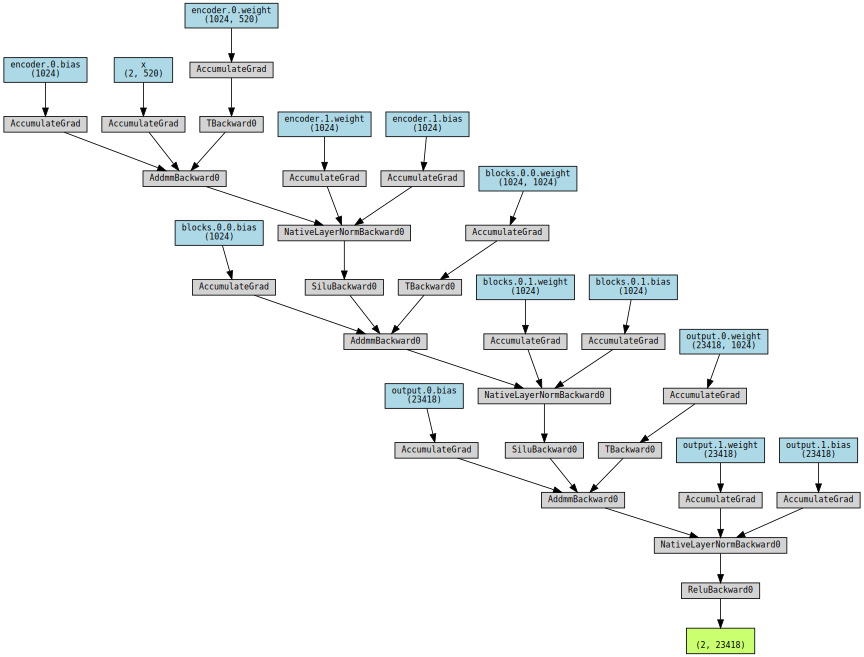

In [7]:
class MSCIModel(torch.nn.Module):

    def __init__(self, cfg):
        super().__init__()
        input_size, hidden_size, n_layers, output_size, activation, dropout, skip_connection = cfg['N_FEATURES'], cfg['HIDDEN_SIZE'], cfg['N_LAYERS'], cfg['N_TARGETS'], cfg['ACTIVATION'], cfg['DROPOUT'], cfg['SKIP_CONNECTION']

        self.skip_connection = skip_connection
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.LayerNorm(hidden_size),
            activation(),
        )
        self.blocks = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.LayerNorm(hidden_size),
                activation(),
            )
            for _ in range(n_layers)]
        )

        self.output = torch.nn.Sequential(
            *(
                    [torch.nn.Dropout(0.1)] if dropout else [] +
                    [
                        torch.nn.Linear(hidden_size, output_size),
                        torch.nn.LayerNorm(output_size),
                        torch.nn.ReLU(),
                    ]
            )
        )

    def forward(self, x):
        x = self.encoder(x)
        for block in self.blocks:
            if self.skip_connection:
                x = block(x) + x
            else:
                x = block(x)
        x = self.output(x)
        return x


# quick test

cfg = copy.copy(CFG)
cfg['N_LAYERS'] = 1
m = MSCIModel(cfg)
print(m)
print(m.forward(torch.randn(2, cfg['N_FEATURES'])))


x = torch.randn(2, cfg['N_FEATURES']).requires_grad_(True)
y = m(x)   
make_dot(y, params=dict(list(m.named_parameters()) + [('x', x)]))


# Training

Differentiable correlation error function.
We test that it's correct by comparing to `torch.corrcoef`

In [8]:
class CorrError():
    def __init__(self, reduction='mean', normalize=True):
        self.reduction, self.normalize = reduction, normalize

    def __call__(self, y, y_target):
        y = y - torch.mean(y, dim=1).unsqueeze(1)
        y_target = y_target - torch.mean(y_target, dim=1).unsqueeze(1)
        loss = -torch.sum(y * y_target, dim=1) / (y_target.shape[-1] - 1)  # minus because we want gradient ascend
        if self.normalize:
            s1 = torch.sqrt(torch.sum(y * y, dim=1) / (y.shape[-1] - 1))
            s2 = torch.sqrt(torch.sum(y_target * y_target, dim=1) / (y_target.shape[-1] - 1))
            loss = loss / s1 / s2
        if self.reduction == 'mean':
            return torch.mean(loss)
        return loss


# quick test
a = torch.tensor([[0, 1, 1., 0.1, 0.3, 0.4]])
b = torch.tensor([[0, 0, 1., 10, 10, -13]])

corr1 = CorrError()(a, b).item()
corr2 = torch.corrcoef(torch.stack([a[0], b[0]]))[0, 1].item()
assert abs(-corr1 - corr2) < 1e-5

CorrError(reduction='none')(torch.randn(2, 3), torch.randn(2, 3))

tensor([-0.3602,  0.3328])

In [9]:
def get_parameter_names(model, forbidden_layer_types):
    """
    Returns the names of the model parameters that are not inside a forbidden layer.
    """
    result = []
    for name, child in model.named_children():
        result += [
            f"{name}.{n}"
            for n in get_parameter_names(child, forbidden_layer_types)
            if not isinstance(child, tuple(forbidden_layer_types))
        ]
    # Add model specific parameters (defined with nn.Parameter) since they are not in any child.
    result += list(model._parameters.keys())
    return result

def adamw_optimizer(model, weight_decay):
    decay_parameters = get_parameter_names(model, [torch.nn.LayerNorm])
    decay_parameters = [name for name in decay_parameters if "bias" not in name]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters],
            "weight_decay": weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
            "weight_decay": 0.0,
        },
    ]
    return torch.optim.AdamW(optimizer_grouped_parameters)


# quick test
adamw_optimizer(torch.nn.Linear(3, 4), 0.001).step()

In [10]:
def evaluate(model, ds_eval, cfg, batch_progress):
    dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size=cfg['BATCH_SIZE'], num_workers=cfg['NUM_WORKERS'])

    with torch.no_grad():
        model.eval()
        with tqdm(dl_eval, miniters=100, desc='Batch', disable=not batch_progress) as progress:
            scores = []
            mses = []
            for batch_idx, (X, y) in enumerate(progress):
                y_pred = model.forward(X.to(DEVICE))
                score = CorrError()(y_pred.detach(), y.to(DEVICE)).item()
                progress.set_description(f'Eval Loss: {score:02f}', refresh=False)
                scores.append(score)
                mses.append(torch.nn.MSELoss()(y_pred.detach(), y.to(DEVICE)).item())

            score = np.mean(scores)
            mses = np.mean(mses)
            model.train()
            return score, mses


In [11]:
def train(cfg, ds_train, ds_eval, wandb_run=None, batch_progress=True, store_best=True, name=''):
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=cfg['BATCH_SIZE'], num_workers=cfg['NUM_WORKERS'])

    model = MSCIModel(cfg)
    model.to(DEVICE)
    model.train()
    best_score = 1.

    if cfg['ADAMW']:
        optim = adamw_optimizer(model, cfg['WEIGHT_DECAY'])
    else:
        optim = torch.optim.Adam(model.parameters(), lr=(cfg['MAX_LR']))

    if cfg['MSE_LOSS']:
        criterion = torch.nn.MSELoss()
    else:
        criterion = CorrError()

    if cfg['SCHEDULER'] == 'onecycle':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=(cfg['MAX_LR']), epochs=cfg['EPOCHS'],
                                                        steps_per_epoch=len(dl_train))
    else:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.3)

    with tqdm(range(cfg['EPOCHS']), desc='Epoch') as epoch_progress:
        for epoch in epoch_progress:
            # ************** train cycle **************
            mses = []
            scores = []
            with tqdm(dl_train, miniters=100, desc='Batch', disable=not batch_progress) as progress:
                for batch_idx, (X, y) in enumerate(progress):
                    y_pred = model.forward(X.to(DEVICE))
                    loss = criterion(y_pred, y.to(DEVICE))
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    if cfg['SCHEDULER'] == 'onecycle':
                        scheduler.step()

                    score = CorrError()(y_pred.detach(), y.to(DEVICE)).item()
                    scores.append(score)
                    mses.append(torch.nn.MSELoss()(y_pred.detach(), y.to(DEVICE)).item())
                    progress.set_description(f'Loss: {score:02f}', refresh=False)
                    if wandb_run is not None:
                        wandb_run.log({'lr': float(scheduler.get_last_lr()[0]),
                                       'train_score': score,
                                       'train_loss': loss.item(),
                                       'epoch': epoch})
            if wandb_run is not None:
                wandb_run.log({'train_epoch_score': np.mean(scores), 'train_epoch_mse': np.mean(mses)})
            if cfg['SCHEDULER'] != 'onecycle':
                scheduler.step()

            # ************** eval cycle **************
            score, mses = evaluate(model, ds_eval, cfg, batch_progress)
            if wandb_run is not None:
                wandb_run.log({'eval_score': score, 'eval_mse': mses})
            if score < best_score:
                best_score = score
                if store_best:
                    !mkdir -p {MODELS_ROOT}
                    torch.save(model.state_dict(), f'{cfg["WANDB_PROJECT"]}-{name}.pth')
            epoch_progress.set_description(f'Epochs, eval loss:{score:.03f}')
    return best_score

In [12]:
def kfold_split(ds):
    fold_sizes = [len(ds) // N_FOLDS] * (N_FOLDS - 1) + [len(ds) // N_FOLDS + len(ds) % N_FOLDS]
    ds_folds = torch.utils.data.random_split(ds, fold_sizes, generator=torch.Generator().manual_seed(42))
    for fold in range(N_FOLDS):
        yield torch.utils.data.ConcatDataset(ds_folds[:fold] + ds_folds[fold + 1:]), ds_folds[fold]

# quick test
for ds_train, ds_test in kfold_split(list(range(10))):
    print([i for i in ds_train], [i for i in ds_test])

[1, 8, 4, 5, 0, 9, 3, 7] [2, 6]
[2, 6, 4, 5, 0, 9, 3, 7] [1, 8]
[2, 6, 1, 8, 0, 9, 3, 7] [4, 5]
[2, 6, 1, 8, 4, 5, 3, 7] [0, 9]
[2, 6, 1, 8, 4, 5, 0, 9] [3, 7]


In [13]:
if TRAIN:
    ds_data = load_dataset()
    for fold, (ds_train, ds_eval) in enumerate(tqdm(kfold_split(ds_data), desc='Train fold', total=N_FOLDS)):
        with wandb.init(project=CFG['WANDB_PROJECT'], name=f'pytorch-{fold}') as run:
            train(CFG, ds_train, ds_eval, wandb_run=run, batch_progress=False, name=str(fold))

Wandb output for Multiome SVD training:

<img src="https://images2.imgbox.com/d2/98/Dm7OTXD3_o.png" alt="image host"/>

# Cross-validation

In [14]:
def load_model(fname):
    model = MSCIModel(CFG)
    model.load_state_dict(torch.load(fname))
    return model

In [15]:
if CROSS_VALIDATE:
    ds = load_dataset()
    scores = []
    for fold, (_, ds_eval) in enumerate(tqdm(kfold_split(ds), desc='Evaluating Folds', total=N_FOLDS)):
        model = load_model(f'{MODELS_ROOT}/{CFG["WANDB_PROJECT"]}-{fold}.pth').to(DEVICE)
        scores, mses = evaluate(model, ds_eval, CFG, batch_progress=False)
        del model, ds_eval
        gc.collect()
    print('CV score:', -np.mean(scores))

# Optuna Hyperparameters Tuning

In [16]:
import copy


def objective(trial: optuna.trial.Trial, ds_data):
    is_adamw = trial.suggest_categorical('adamw', [True, False])
    weight_decay = 0.
    if is_adamw:
        weight_decay = trial.suggest_float('weight_decay', 0.0001, 0.1, log=True)
    max_lr = trial.suggest_float('max_lr', 0.0001, 0.01, log=True)
    n_layers = trial.suggest_int('n_layers', 2, 8, log=True)
    hidden_size = trial.suggest_int('hidden_size', 128, 4096, log=True)
    activation = eval(trial.suggest_categorical('activation', ['torch.nn.SiLU', 'torch.nn.GELU', 'torch.nn.ReLU']))
    dropout = trial.suggest_categorical('dropout', [True, False])
    skip_connection = trial.suggest_categorical('skip', [True, False])

    ds_train, ds_test = next(iter(kfold_split(ds_data)))
    cfg = copy.copy(CFG)
    cfg.update({
        'ADAMW': is_adamw,
        'WEIGHT_DECAY': weight_decay,
        'MAX_LR': max_lr,
        'N_LAYERS': n_layers,
        'HIDDEN_SIZE': hidden_size,
        'ACTIVATION': activation,
        'DROPOUT': dropout,
        'SKIP_CONNECTION': skip_connection,
        'EPOCHS': 5,
    })
    return train(cfg, ds_train, ds_test, wandb_run=None, batch_progress=False, store_best=False)

def run_optuna():
    ds_data = load_dataset()
    study = optuna.create_study(direction=StudyDirection.MINIMIZE)
    study.optimize(lambda trial: objective(trial, ds_data), n_trials=OPTUNA_N_TRIALS)
    print(study.best_params)

if OPTUNA:
    run_optuna()

# Prediction

In [17]:
def load_ds_test():
    df_meta = load_meta()
    if 'sparse.npz' in CFG['TEST_INPUTS_VALUES_NPZ']:
        ds_test = MSCIDatasetSparse(
            df_meta,
            np.load(CFG['TEST_INPUTS_IDXCOL_NPZ'], allow_pickle=True)['index'],
            sparse.load_npz(CFG['TEST_INPUTS_VALUES_NPZ']),
        )
    else:        
        ds_test = MSCIDatasetSVD(
            df_meta,
            np.load(CFG['TEST_INPUTS_IDXCOL_NPZ'], allow_pickle=True)['index'],
            np.load(CFG['TEST_INPUTS_VALUES_NPZ'])['values'],
        )
    return ds_test

In [18]:
def predict(models, ds):
    with torch.no_grad():
        dl_eval = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False, num_workers=1)
        preds = []
        with tqdm(dl_eval, miniters=100, desc='Predict') as progress:
            for batch_idx, (X) in enumerate(progress):
                pred = None
                for model in models:
                    model.eval()
                    pred_fold = model.forward(X.to(DEVICE))
                    if pred is None:
                        pred = pred_fold / len(models)
                    else:
                        pred += pred_fold / len(models)
                preds.append(pred)
        preds = torch.concat(preds)                
        return preds

In [19]:
def predict_nfold():
    ds_test = load_ds_test()
    models = [load_model(f'{MODELS_ROOT}/{CFG["WANDB_PROJECT"]}-{fold}.pth').to(DEVICE) for fold in tqdm(range(N_FOLDS), desc='Loading models')]
    preds = predict(models, ds_test)
    del models
    del ds_test
    gc.collect()
    return preds.cpu()
    

def predict_and_save():
    preds = predict_nfold()
    np.save(CFG["TECHNOLOGY"], preds)
    
if PREDICT:
    predict_and_save()
    gc.collect()    

Loading models:   0%|          | 0/5 [00:00<?, ?it/s]

Predict:   0%|          | 0/874 [00:00<?, ?it/s]

# Submission

In [20]:
def gen_preds(df_eval, pred_file, train_targets_idxcol, test_inputs_idxcol):
    cite_pred = np.load(pred_file)
    cols = np.load(train_targets_idxcol, allow_pickle=True)['columns']
    cols_idx = dict(zip(cols, range(len(cols))))
    cells = np.load(test_inputs_idxcol, allow_pickle=True)['index']
    cells_idx = dict(zip(cells, range(len(cells))))
    return cite_pred[df_eval.cell_id.map(cells_idx), df_eval.gene_id.map(cols_idx)]

In [21]:
def gen_submission():
    df_meta = pd.read_parquet(META_FILE)
    df_evaluation = pd.read_parquet(f'{SPARSE_ROOT}/evaluation.parquet')
    print('Loaded', f'{SPARSE_ROOT}/evaluation.parquet', df_evaluation.shape)

    # citeseq
    df_cite_eval = df_evaluation[df_evaluation.cell_id.isin(df_meta.query('technology == "citeseq"').cell_id)]
    if os.path.exists(f'CITEseq.npy'):
        cite_eval_pred = gen_preds(df_cite_eval, f'{PREDICTIONS_ROOT}/CITEseq.npy', f'{SPARSE_ROOT}/train_cite_targets_idxcol.npz', f'{SPARSE_ROOT}/test_cite_inputs_idxcol.npz')
        print('Loaded citeseq prediction', cite_eval_pred.shape)
    else:
        cite_eval_pred = np.zeros(df_cite_eval.shape[0])
        print('Empty citeseq prediction', cite_eval_pred.shape)
    del df_cite_eval
    gc.collect()

    # multiome
    df_multi_eval = df_evaluation[df_evaluation.cell_id.isin(df_meta.query('technology == "multiome"').cell_id)]
    if os.path.exists(f'Multiome.npy'):
        multi_eval_pred = gen_preds(df_multi_eval, f'{PREDICTIONS_ROOT}/Multiome.npy', f'{SPARSE_ROOT}/train_multi_targets_idxcol.npz', f'{SPARSE_ROOT}/test_multi_inputs_idxcol.npz')
        print("Loaded Multiome predictions", multi_eval_pred.shape)
    else:
        multi_eval_pred = np.zeros(df_multi_eval.shape[0])
        print("Empty Multiome predictions", multi_eval_pred.shape)
    del df_multi_eval, df_meta
    gc.collect()

    if SUBMISSION:    
        print('Generating pure submission')
        df_evaluation['target'] = np.concatenate([cite_eval_pred, multi_eval_pred])
        df_evaluation[['row_id', 'target']].to_csv('submission.csv', index=False)
    elif SUBMISSION_FOR_PATCHING is not None:
        del df_evaluation
        gc.collect()
        df_sub = pd.read_csv(SUBMISSION_FOR_PATCHING)
        print('Generating patched submission from', SUBMISSION_FOR_PATCHING, df_sub.shape)
        if PATCH_CITESEQ:
            preds = np.concatenate([cite_eval_pred, df_sub['target'].tail(len(multi_eval_pred)).values])
            print("Patching CITEseq data", preds.shape)
            df_sub['target'] = preds
        else:
            multi_patch = np.concatenate([df_sub['target'].head(len(cite_eval_pred)).values, multi_eval_pred])
            print("Patching Multiome data", multi_patch.shape)
            df_sub['target'] = multi_patch
        df_sub.to_csv('submission.csv', index=False)
    print('Done')
                

gen_submission()

Loaded ../input/multimodal-single-cell-as-sparse-matrix/evaluation.parquet (65744180, 3)
Empty citeseq prediction (6812820,)
Loaded Multiome predictions (58931360,)
Generating patched submission from ../input/lb-0-858-normalized-ensembles-for-pearson-s-r//submission.csv (65744180, 2)
Patching Multiome data (65744180,)
Done


<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>